Exploring Segregation in NYC SChools
==================================



In [1]:
# automatically reload changes we make to schools.py and ui.py
%load_ext autoreload
%autoreload 2

# load the demographic data
import pandas as pd

import numpy as np

import pingouin as pg

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import chi2

import statsmodels.api as sm


import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.display import Markdown as md, HTML

from school_data import schools, ui, exams, geo
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# load the demographic data and merge it with the test and location data
df = schools.load_school_demographics()
nys_exams = exams.load_math_ela_long()
school_loc = geo.load_school_locations()
districts = geo.load_districts()

# merge and filter the data
data = df.merge(nys_exams, on=["dbn", "ay"], how="inner")
data = data.query("ay==2018 and grade == 'All Grades'")

# calculate NYSED score percentiles
df["black_hispanic_pct"] = df["black_pct"] + df["hispanic_pct"]

# split the data set into 5 groups, 0..4, with 0 being most white/asian and 4 being most black/hispanic
df["seg"] = pd.qcut(df['black_hispanic_pct'], 5, labels=False)
data["seg"] = pd.qcut(data['mean_scale_score'], 5, labels=False)

In [31]:
# group the data by segregation percentile
aggregates = {
    "dbn":"count",
    "poverty_pct":"mean",
    "black_pct":"mean",
    "hispanic_pct":"mean",
    "white_pct":"mean",
    "asian_pct":"mean"
}
table = data.groupby("seg").agg(aggregates)
table = table.reset_index()

# # format and display the table
labels = {0:"Most Black / Hispanic", 
          1:"More Black / Hispanic",
          2:"Mixed Race / Ethnicity",
          3:"More White / Asian",
          4:"Most White / Asian",
          "New York City":"New York City"}

table.seg = table.seg.map(labels)

city = data.agg(aggregates)
city["seg"] = "New York City"
table = table.append(city.transpose(), ignore_index=True)

table = ui.fmt_table(table, 
             num_cols=["dbn"], 
             pct_cols=["poverty_pct", "black_pct", "hispanic_pct", "white_pct","asian_pct"])

table.columns = ["", 
                 "# Schools", 
                 "% Poverty",
                 "% Black", 
                 "% Hispanic",
                 "% White",
                 "% Asian"]
table

/tmp/ipykernel_7117/3109583470.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(city.transpose(), ignore_index=True)


# Schools % Poverty % Black % Hispanic % White  \
0   Most Black / Hispanic   5,936.0     86.8%   34.8%      50.0%    6.0%   
1   More Black / Hispanic   5,936.0     84.8%   33.5%      49.7%    7.1%   
2  Mixed Race / Ethnicity   5,934.0     80.2%   29.8%      45.2%   10.5%   
3      More White / Asian   5,936.0     70.8%   20.8%      38.0%   19.8%   
4      Most White / Asian   5,934.0     53.1%   10.7%      25.7%   32.0%   
5           New York City  33,596.0     75.5%   27.1%      41.7%   14.7%   

  % Asian  
0    7.3%  
1    7.7%  
2   12.1%  
3   18.5%  
4   27.6%  
5   13.9%

In [32]:
r = pg.corr(df["poverty_pct"], df["seg"])
degs_f = r.n[0] - 2

report_r = f"""
**A Pearson's correlation coefficient** was computed to assess the linear relationship 
between _% poverty_ and _segregation quintile_.

There was a positive correlation between the two variables, r({degs_f}) = {r['r'][0]:.2f}, p = {r['p-val'][0]:.3f}.
"""

md(report_r)




**A Pearson's correlation coefficient** was computed to assess the linear relationship 
between _% poverty_ and _segregation quintile_.

There was a positive correlation between the two variables, r(9999) = 0.62, p = 0.000.


In [3]:
labels = ["Most Black / Hispanic", 
          "More Black / Hispanic",
          "Mixed Race / Ethnicity",
          "More White / Asian",
          "Most White / Asian"]
labels.reverse()


/home/mxc/.virtualenvs/school-data/lib/python3.10/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/mxc/.virtualenvs/school-data/lib/python3.10/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/mxc/.virtualenvs/school-data/lib/python3.10/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/mxc/.virtualenvs/school-data/lib/python3.10/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/mxc/.virtualenvs/school-data/lib/python3.10/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame ind

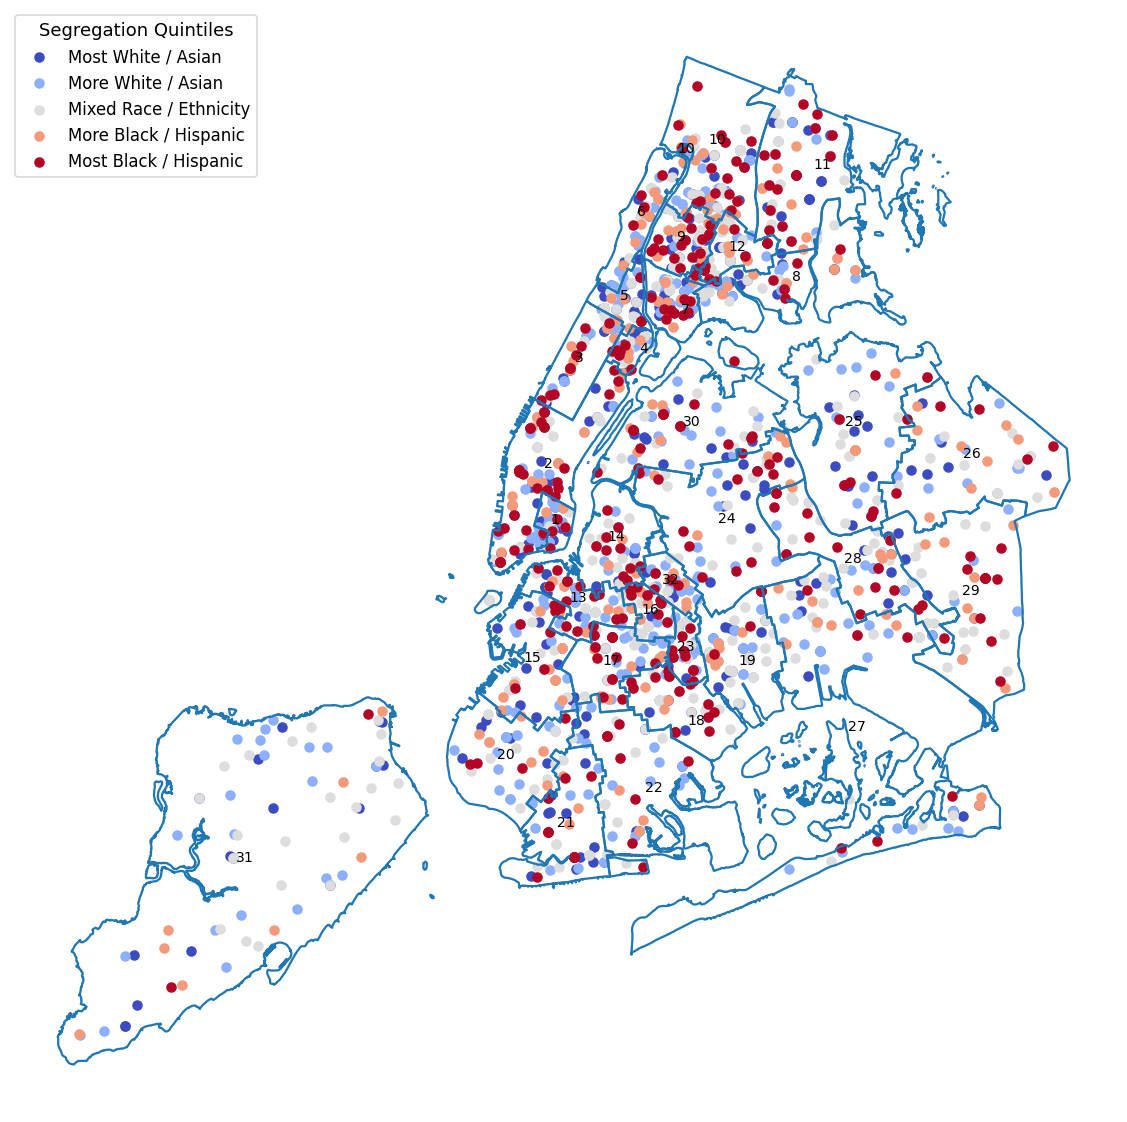

In [4]:
# mrege locations with our data
data = school_loc.merge(data, on="dbn", how="inner")

# get the matplotib figure and axis
fig, ax = plt.subplots(figsize=(16, 16))

# set the "look" for our graph
sns.set_context('talk')
plt.axis('off')
fig.tight_layout()

cmap = plt.get_cmap("coolwarm", len(labels))

# plot one group at a time so we get a legend
for i in range(5):
    school_loc[data.seg == i].plot(ax=ax, color=cmap(i))    

plt.legend(labels, loc='upper left', title='Segregation Quintiles')

districts.boundary.plot(ax=ax)
# this function adds labels after the plot is drawn
# ax is the axis to plot on, districs is the full data set, and district is the column to use for the label
geo.add_labels(ax, districts, "district")
plt.show()

In [63]:
# load the data we need
df = schools.load_school_demographics()
nys_exams = exams.load_math_ela_long()
nys_exams = nys_exams[nys_exams["mean_scale_score"].notnull()]
school_loc = geo.load_school_locations()
districts = geo.load_districts()



# merge and filter the data
data = df.merge(nys_exams, on=["dbn", "ay"], how="inner")

data = data.query("ay==2018 and grade == 'All Grades'")
# calculate NYSED score percentiles
data["score_percentile"] = pd.qcut(data['mean_scale_score'], 5, labels=False)
df["black_hispanic_pct"] = df["black_pct"] + df["hispanic_pct"]
df["black_hispanic_n"] = df["black_n"] + df["hispanic_n"]

# split the data set into 5 groups, 0..4, with 0 being most white/asian and 4 being most black/hispanic
df["seg"] = pd.qcut(df['black_hispanic_pct'], 5, labels=False)
data["seg"] = pd.qcut(data['mean_scale_score'], 5, labels=False)
school_loc = school_loc.merge(data, on="dbn", how="inner")

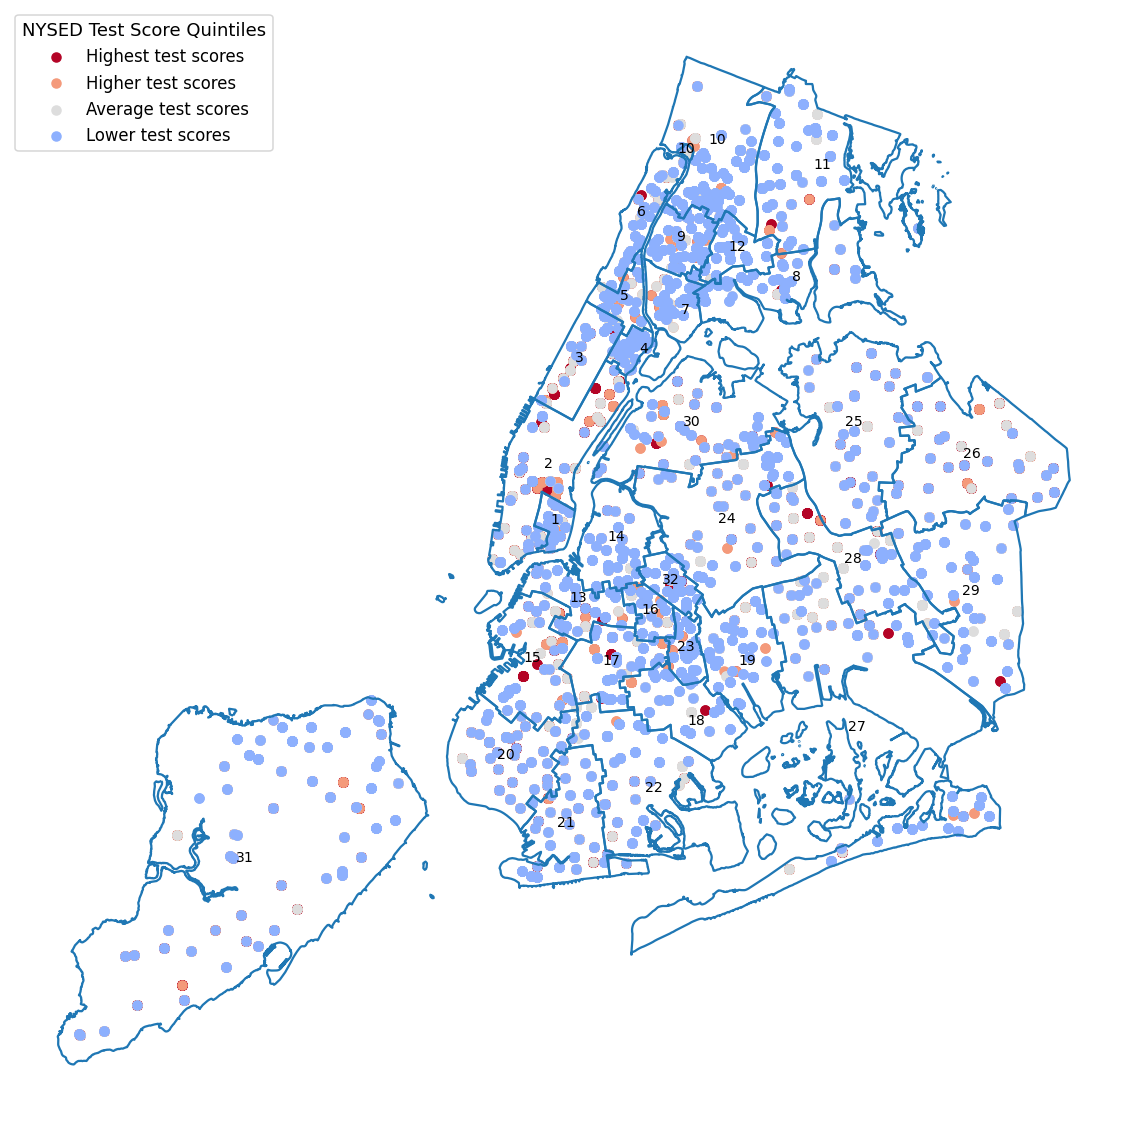

In [66]:
# get the matplotib figure and axis
fig, ax = plt.subplots(figsize=(16, 16))

# use these for the legend instead of 0,1,2,3,4
legend_labels = ["Highest test scores",
                 "Higher test scores",
                 "Average test scores", 
                 "Lower test scores", 
                 "Lowest test scores"]

# set the "look" for our graph
sns.set_context('talk')
plt.axis('off')
fig.tight_layout()
cmap = plt.get_cmap("coolwarm", len(legend_labels))

# plot one group at a time so we get a legend
for i in range(4,0,-1):
    school_loc[school_loc.score_percentile == i].plot(ax=ax, color=cmap(i))


plt.legend(legend_labels, loc='upper left', title='NYSED Test Score Quintiles')
districts.boundary.plot(ax=ax)
geo.add_labels(ax, districts, "district")
plt.show()

In [58]:
len(school_loc[school_loc.score_percentile == 0][["dbn", "mean_scale_score", "score_percentile"]])
data.grade.unique()

array(['3', '4', '5', 'All Grades', '6', '7', '8'], dtype=object)

array([2016, 2017, 2018])

OLS Linear Regression
----------------------------------

We're going to run a linear regression prediction with several different sets of factors to
see which combination creates the strongest predictive model.

Because the training and testing sets are randomized we will get slightly different results
each time we run the code in this cell. It appears that the factors that total enrollment has
no predictive power and that including poverty_pct without eni_pct produces slightly
better predictions.

In [15]:
# get only the data that has test scores
data = data[data["mean_scale_score"].notnull()]
factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter', 'seg']

model = LinearRegression()

# shuffle our data frame so test, train are randomized, but the same across runs
data = data.sample(frac=1).reset_index(drop=True)

# make a small function so that we can report r2 and mse for different factors

def show_predict(factors, title):
    X = data[factors]
    y = data['mean_scale_score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.3)

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    report = f"""
**{title}**

- factors: {factors}
- r2: {r2}
- rmse: {rmse}
"""
    display(md(report))

factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter']
show_predict(factors, "OLS Predictions: No Segregation" )
factors += ["seg"]
show_predict(factors, "OLS Predictions: With Segregation" )


**OLS Predictions: No Segregation**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'charter']
- r2: 0.43121243774399853
- rmse: 8.765063832578452



**OLS Predictions: With Segregation**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'charter', 'seg']
- r2: 0.8941788826826974
- rmse: 3.780647696554431


Partial Least Squares
===================

In [16]:
X = data[factors]
y = data['mean_scale_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

pls = PLSRegression(n_components=len(factors))
pls.fit(X_train, y_train)


predictions = pls.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
md(f"""
**PLS Predictions**

- factors: {factors}
- r2: {r2}
- rmse: {rmse}
""")



**PLS Predictions**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'charter', 'seg']
- r2: 0.8935150797158298
- rmse: 3.803435174421769


In [17]:
# fit both models with the full data and show the correlations
ols_fit = model.fit(X, y)
pls_fit = pls.fit(X, y)

coef_table = pd.DataFrame(columns=["factor", "pls-coef", "ols-coef"])

coef_table.factor = factors

coef_table["pls-coef"] = [x[0] for x in pls.coef_]
coef_table["ols-coef"] = [x for x in model.coef_]

# coef_table.join(ols_df, on="factor")
coef_table

factor   pls-coef  ols-coef
0     asian_pct  -0.502301 -2.521485
1     black_pct  -1.167738 -4.376453
2  hispanic_pct  -0.797357 -3.120187
3     white_pct  -1.012294 -5.211891
4       swd_pct  -0.188886 -2.855248
5       ell_pct  -0.583584 -4.366907
6   poverty_pct  -1.021308 -4.679482
7       charter   0.093267  0.805050
8           seg  10.231126  7.260639

### Graph of PLS coefficients

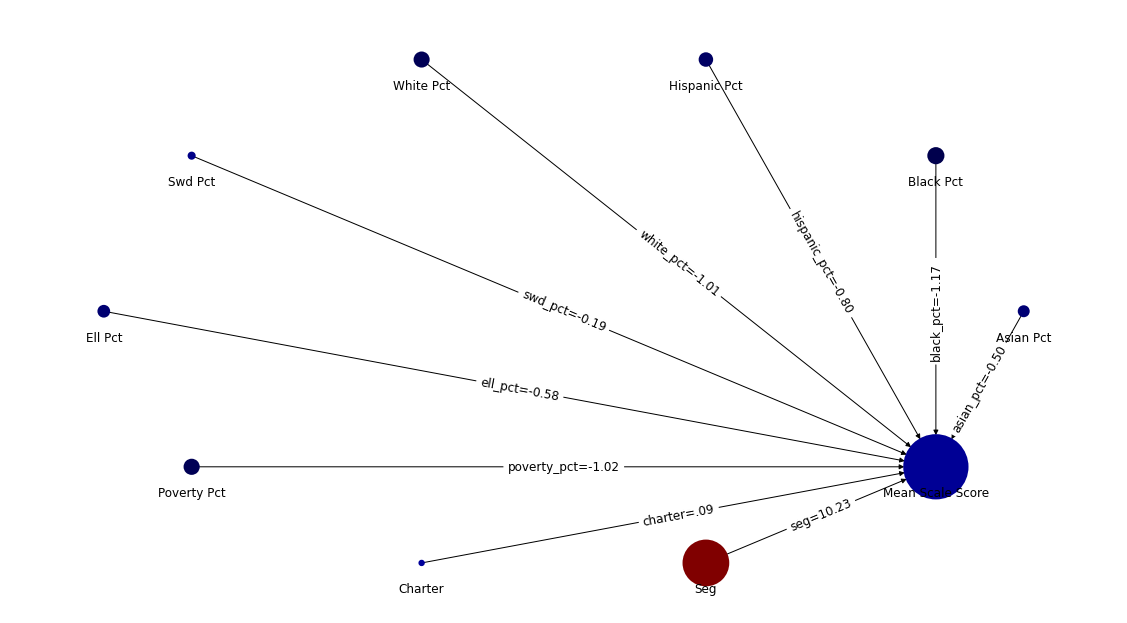

### Graph of OLS coefficients

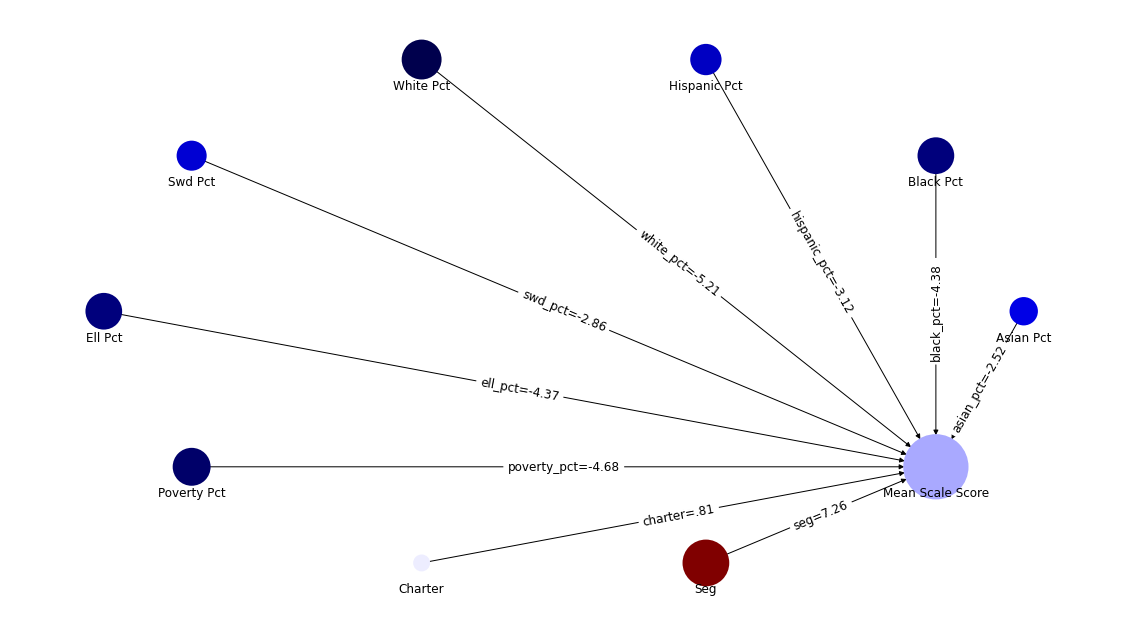

In [19]:
display(md("### Graph of PLS coefficients"))
coefs = [x[0] for x in pls.coef_]
ui.network_map("mean_scale_score", factors, coefs , None)

display(md("### Graph of OLS coefficients"))
coefs = [x for x in model.coef_]
ui.network_map("mean_scale_score", factors, coefs , None)